<a href="https://colab.research.google.com/github/GuysBarash/Riddles/blob/master/jugs_of_water/jugs_of_water.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
import itertools
from copy import copy
import networkx as nx
import matplotlib.pyplot as plt

# Parameters

Max capacity of each jar

In [125]:
capacities = [10, 5, 6]

Starting state

In [126]:
water_state = [0, 5, 6]

Win condition

In [127]:
winning_state = [8, -1, -1]  # -1 is "don't care"

# Code

Define classes

In [128]:
class State:
  @staticmethod
  def _list_to_sig(l):
      return '_'.join([str(int(t)) for t in l])

  @staticmethod
  def _sig_to_list(sig):
      return [int(t) for t in sig.split('_')]

  def __init__(self, water_state=None, sig=None):
      if water_state is not None:
          sig = State._list_to_sig(water_state)
      elif sig is not None:
          water_state = State._sig_to_list(sig)
      else:
          raise Exception('Cannot initialize state without water_state or sig')

      self.sig = sig
      self.water_state = water_state

  def get(self):
      return self.water_state

  def get_sig(self):
      return self.sig

  def __str__(self):
      return self.get_sig()

In [129]:
class Board:
  def __init__(self, capacities, winning_state):
      self.capacities = capacities
      self.winning_state = winning_state
      self.board_size = len(self.capacities)

      ls = range(self.board_size)
      self.moves_list = [t for t in (itertools.product(ls, ls)) if t[0] != t[1]]

  def is_legal_state(self, state):
      state_l = state.get()
      if len(state_l) != len(self.capacities):
          raise Exception(
              f"Bad state length. State is {len(state_l)} long. while capacities are {len(self.capacities)} long.")
      is_legal_list = [state_l[i] <= self.capacities[i] for i in range(len(state_l))]
      return all(is_legal_list)

  def is_winning_state(self, state):
      state_l = state.get()

      winning = [False] * len(state_l)
      for i in range(len(state_l)):
          is_dc = self.winning_state[i] == -1
          is_hit = self.winning_state[i] == state_l[i]
          winning[i] = is_dc or is_hit
      return all(winning)

  def apply(self, state, action):
      state_l = copy(state.get())

      from_jar = action[0]
      to_jar = action[1]

      amount_to_move = self.capacities[to_jar] - state_l[to_jar]
      amount_to_move = min(amount_to_move, state_l[from_jar])

      state_l[from_jar] -= amount_to_move
      state_l[to_jar] += amount_to_move

      n_state = State(water_state=state_l)
      if self.is_legal_state(n_state):
          return n_state
      else:
          return None

  def get_next_states(self, state):
      state_l = state.get()
      ret = [self.apply(state, action) for action in self.moves_list]
      ret = [s for s in ret if s is not None]
      return ret

In [130]:
def bfs(board, start_state):
  G = nx.DiGraph(directed=True)
  visited = dict()
  wins = list()

  q = list()
  q.append(start_state.get_sig())
  visited[start_state.get_sig()] = True
  while q:
      s = q.pop(0)
      s_state = State(sig=s)
      adjacent = board.get_next_states(s_state)

      if board.is_winning_state(s_state):
          wins.append(s_state.get_sig())

      for st in adjacent:
          st_sig = st.get_sig()
          G.add_edge(s_state.get_sig(), st_sig)
          if not visited.get(st_sig, False):
              q.append(st_sig)
              visited[st_sig] = True
  return wins, G

Run code

In [131]:
board = Board(capacities, winning_state=winning_state)
cstate = State(water_state=water_state)

In [132]:
win_states, G = bfs(board, cstate)

# Results

In [133]:
reachables = list(G.nodes())
amounts = list()
for s in reachables:
    for n in [int(t) for t in s.split("_")]:
        amounts.append(str(n))
amounts = sorted(list(set(amounts)))
print(f"Total of {len(reachables)} reachable states.")
print(f"It is possible to measure these amounts: [{', '.join(amounts)}]")

Total of 21 reachable states.
It is possible to measure these amounts: [0, 1, 10, 2, 3, 4, 5, 6, 7, 8, 9]


In [134]:
print(f"Winning paths: ({len(win_states)} paths found)")
all_good_edges = [[]] * len(win_states)
for idx, win_state in enumerate(win_states):
    short_path = nx.shortest_path(G, str(cstate), str(win_state))
    all_good_edges[idx] = [(short_path[i],(short_path[i+1])) for i in range(len(short_path)-1)]
    msg = '[' + '] --> ['.join(short_path) + ']'
    msg = f'({idx:>3})\t' + msg + f'\t\t Steps: {len(short_path)}'
    print(msg)

Winning paths: (2 paths found)
(  0)	[0_5_6] --> [6_5_0] --> [10_1_0] --> [4_1_6] --> [4_5_2] --> [9_0_2] --> [9_2_0] --> [3_2_6] --> [3_5_3] --> [8_0_3]		 Steps: 10
(  1)	[0_5_6] --> [6_5_0] --> [6_0_5] --> [1_5_5] --> [1_4_6] --> [7_4_0] --> [7_0_4] --> [2_5_4] --> [2_3_6] --> [8_3_0]		 Steps: 10


# Visualization

In [135]:
def color_map_edges(e,all_good_edges,width_mode=False):
  if e in all_good_edges:
    if width_mode:
      return 3
    else:
      return 'BLACK'
  else:
    if width_mode:
      return 1
    else:
      return 'GREY'

def color_map(t,board):
  node = State(sig=t)
  if board.is_winning_state(node): 
    return 'YELLOW'
  elif str(State(water_state)) == str(node):
    return 'BLUE'
  else:
    return 'RED'

In [136]:
edge_color = [color_map_edges(edge,all_good_edges[1]) for edge in G.edges()]
e_weights = [color_map_edges(edge,all_good_edges[1],True) for edge in G.edges()]
node_color = [color_map(node,board) for node in G.nodes()]

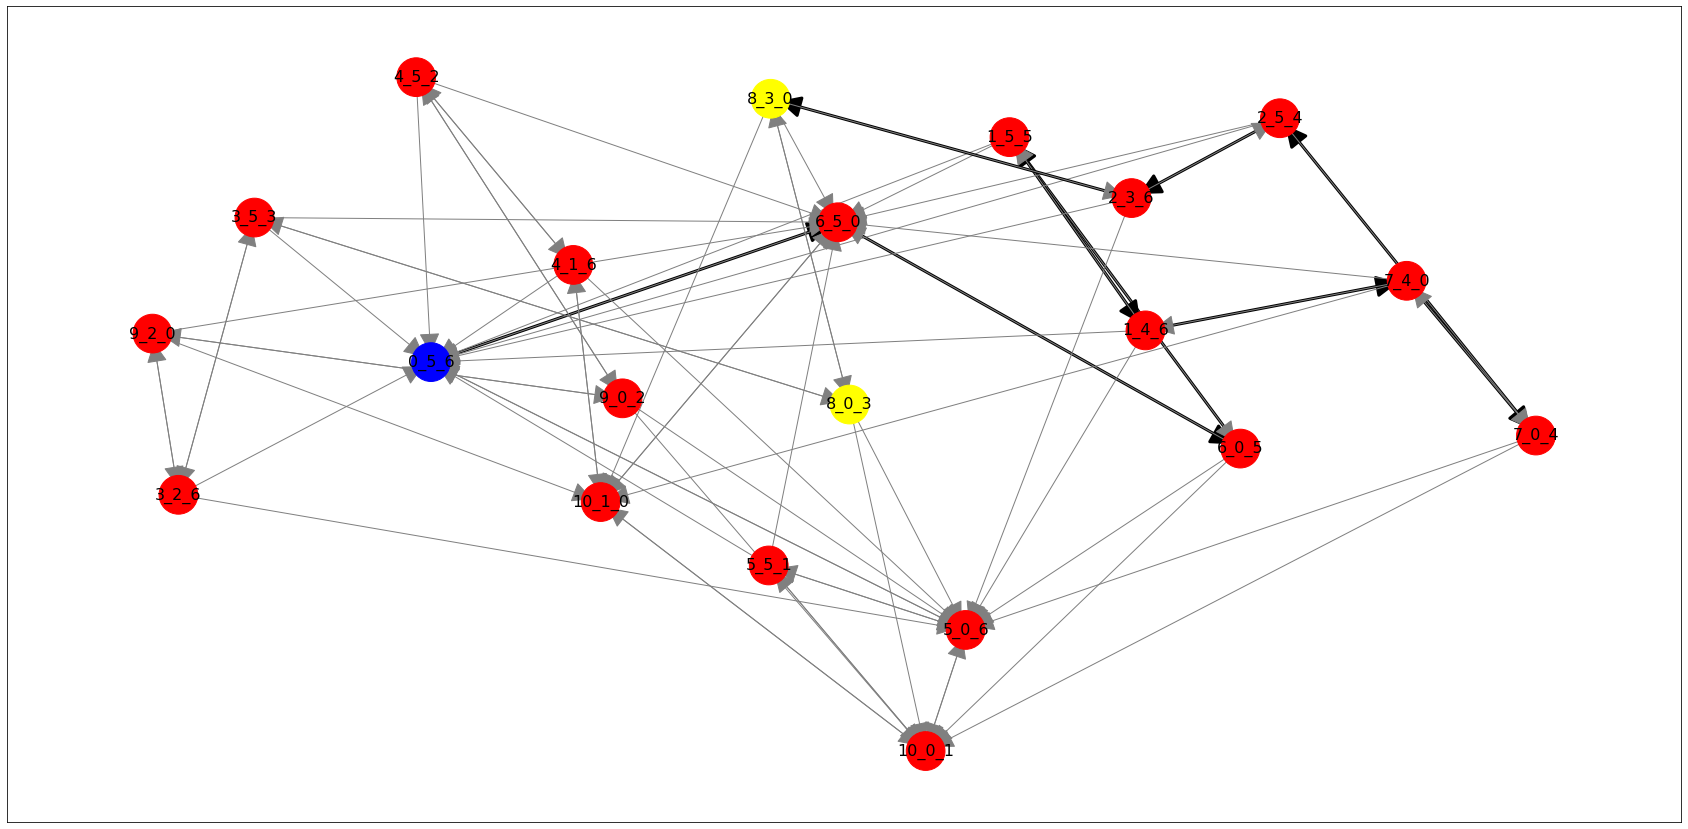

In [137]:
options = {
    'arrowstyle': '-|>',
    'arrowsize': 45,
}

pos = nx.layout.spring_layout(G)

plt.rcParams["figure.figsize"] = (30, 15)

nx.draw_networkx_edges(G, pos, width=e_weights,edge_color=edge_color, **options)
nx.draw_networkx_nodes(G, pos,node_size=1500,node_color=node_color)
nx.draw_networkx_labels(G,pos,font_size=16,font_color='BLACK')
plt.show()